In [1]:
# instalar as dependências
!apt-get update -qq
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!tar xf spark-3.1.2-bin-hadoop2.7.tgz
!pip install -q findspark

In [1]:
# determinado as variáveis de ambiente

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

In [2]:
# acha a instalação do spark

import findspark
findspark.init()

In [3]:
# Cria uma seção Spark

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .appName("Iniciando com Spark") \
    .getOrCreate()

In [4]:
spark

In [75]:
# Leitura do arquivo csv
%time netflix = spark.read.csv('netflix_titles_2021.csv', sep= ',' , header=True, multiLine=True)

CPU times: user 3.13 ms, sys: 670 µs, total: 3.8 ms
Wall time: 211 ms


In [76]:
%time netflix.show()

+-------+-------+--------------------+--------------------+--------------------+--------------------+------------------+------------+------+---------+--------------------+--------------------+
|show_id|   type|               title|            director|                cast|             country|        date_added|release_year|rating| duration|           listed_in|         description|
+-------+-------+--------------------+--------------------+--------------------+--------------------+------------------+------------+------+---------+--------------------+--------------------+
|     s1|  Movie|Dick Johnson Is Dead|     Kirsten Johnson|                null|       United States|September 25, 2021|        2020| PG-13|   90 min|       Documentaries|As her father nea...|
|     s2|TV Show|       Blood & Water|                null|Ama Qamata, Khosi...|        South Africa|September 24, 2021|        2021| TV-MA|2 Seasons|International TV ...|After crossing pa...|
|     s3|TV Show|           Ganglan

In [77]:
#verificando o tamanho do dataset (shape)
%time netflix.count(), len(netflix.columns)

CPU times: user 2.46 ms, sys: 530 µs, total: 2.99 ms
Wall time: 180 ms


(8807, 12)

In [78]:
colunas = {'type':'tipo', 'title':'titulo', 'director':'diretor', 'cast':'elenco',
            'country':'pais', 'date_added':'adicionado_em','release_year':'ano_lancamento',
            'rating':'avaliacao', 'duration':'duracao', 'listed_in':'categorias', 'description':'descricao'}

In [79]:
%%time
for old_name, new_name in colunas.items():
  netflix = netflix.withColumnRenamed(old_name, new_name)

CPU times: user 4.88 ms, sys: 0 ns, total: 4.88 ms
Wall time: 70.8 ms


In [80]:
%time netflix.show(10)

+-------+-------+--------------------+--------------------+--------------------+--------------------+------------------+--------------+---------+---------+--------------------+--------------------+
|show_id|   tipo|              titulo|             diretor|              elenco|                pais|     adicionado_em|ano_lancamento|avaliacao|  duracao|          categorias|           descricao|
+-------+-------+--------------------+--------------------+--------------------+--------------------+------------------+--------------+---------+---------+--------------------+--------------------+
|     s1|  Movie|Dick Johnson Is Dead|     Kirsten Johnson|                null|       United States|September 25, 2021|          2020|    PG-13|   90 min|       Documentaries|As her father nea...|
|     s2|TV Show|       Blood & Water|                null|Ama Qamata, Khosi...|        South Africa|September 24, 2021|          2021|    TV-MA|2 Seasons|International TV ...|After crossing pa...|
|     s3|T

In [81]:
# Verificando os valores ausentes
from pyspark.sql import functions as f

%time frequencia = netflix.select([f.count(f.when(f.isnull(c), 1)).alias(c) for c in netflix.columns])
%time percentual_na = netflix.select([(f.count(f.when(f.isnull(c), 1))/netflix.count() *100).alias(c) for c in netflix.columns])
%time percentual_na = percentual_na.select([f.round(c,2).alias(c) for c in percentual_na.columns])
%time valores_ausentes = frequencia.unionAll(percentual_na)
%time valores_ausentes.show()

CPU times: user 18.5 ms, sys: 6.71 ms, total: 25.2 ms
Wall time: 170 ms
CPU times: user 43.1 ms, sys: 4.42 ms, total: 47.5 ms
Wall time: 1.88 s
CPU times: user 10.6 ms, sys: 1.98 ms, total: 12.6 ms
Wall time: 109 ms
CPU times: user 1.75 ms, sys: 0 ns, total: 1.75 ms
Wall time: 14.6 ms
+-------+----+------+-------+------+-----+-------------+--------------+---------+-------+----------+---------+
|show_id|tipo|titulo|diretor|elenco| pais|adicionado_em|ano_lancamento|avaliacao|duracao|categorias|descricao|
+-------+----+------+-------+------+-----+-------------+--------------+---------+-------+----------+---------+
|    0.0| 0.0|   0.0| 2634.0| 825.0|830.0|         11.0|           0.0|      4.0|    3.0|       0.0|      0.0|
|    0.0| 0.0|   0.0|  29.91|  9.37| 9.42|         0.12|           0.0|     0.05|   0.03|       0.0|      0.0|
+-------+----+------+-------+------+-----+-------------+--------------+---------+-------+----------+---------+

CPU times: user 9.01 ms, sys: 296 µs, total: 9.

In [82]:
%time valores_ausentes.toPandas().transpose().rename(columns={0:'Frequência', 1:'% de NAs'})


CPU times: user 27.3 ms, sys: 2.61 ms, total: 29.9 ms
Wall time: 432 ms


,Frequência,% de NAs
show_id,0.0,0.00
tipo,0.0,0.00
titulo,0.0,0.00
diretor,2634.0,29.91
elenco,825.0,9.37
pais,830.0,9.42
adicionado_em,11.0,0.12
ano_lancamento,0.0,0.00
avaliacao,4.0,0.05
duracao,3.0,0.03


In [83]:
# verificando os tipos de dados do df
%time netflix.printSchema()

root
 |-- show_id: string (nullable = true)
 |-- tipo: string (nullable = true)
 |-- titulo: string (nullable = true)
 |-- diretor: string (nullable = true)
 |-- elenco: string (nullable = true)
 |-- pais: string (nullable = true)
 |-- adicionado_em: string (nullable = true)
 |-- ano_lancamento: string (nullable = true)
 |-- avaliacao: string (nullable = true)
 |-- duracao: string (nullable = true)
 |-- categorias: string (nullable = true)
 |-- descricao: string (nullable = true)

CPU times: user 332 µs, sys: 1.08 ms, total: 1.42 ms
Wall time: 2.3 ms


In [84]:
# Otimizando o tamanho da variável ano_lancamento

from pyspark.sql.types import IntegerType, StringType

%time netflix = netflix.withColumn('ano_lancamento', netflix['ano_lancamento'].cast(IntegerType()))


CPU times: user 2.83 ms, sys: 0 ns, total: 2.83 ms
Wall time: 16.5 ms


In [85]:
%time netflix.printSchema()

root
 |-- show_id: string (nullable = true)
 |-- tipo: string (nullable = true)
 |-- titulo: string (nullable = true)
 |-- diretor: string (nullable = true)
 |-- elenco: string (nullable = true)
 |-- pais: string (nullable = true)
 |-- adicionado_em: string (nullable = true)
 |-- ano_lancamento: integer (nullable = true)
 |-- avaliacao: string (nullable = true)
 |-- duracao: string (nullable = true)
 |-- categorias: string (nullable = true)
 |-- descricao: string (nullable = true)

CPU times: user 647 µs, sys: 868 µs, total: 1.52 ms
Wall time: 1.48 ms


In [86]:
# adicionando as colunas mes, dia e ano

%time netflix = netflix.withColumn('mes', f.split(netflix['adicionado_em'], ' ').getItem(0))
%time netflix = netflix.withColumn('dia', f.split(netflix['adicionado_em'], ' ').getItem(1))
# substituindo a vírgula da coluna dia por -
%time netflix = netflix.withColumn('dia', f.regexp_replace('dia', ',', ''))
%time netflix = netflix.withColumn('ano', f.split(netflix['adicionado_em'], ' ').getItem(2))
# adicionando / na coluna ano (-yyyy)
#%time netflix = netflix.withColumn("ano", f.concat(f.lit("-"), f.col("ano")))
#%time netflix.show()

CPU times: user 586 µs, sys: 640 µs, total: 1.23 ms
Wall time: 14.3 ms
CPU times: user 1.4 ms, sys: 0 ns, total: 1.4 ms
Wall time: 11.9 ms
CPU times: user 2.41 ms, sys: 55 µs, total: 2.47 ms
Wall time: 16.3 ms
CPU times: user 3.86 ms, sys: 88 µs, total: 3.95 ms
Wall time: 33.3 ms


In [88]:
# Cria um dicionário com os valores dos meses

import calendar

%time meses = dict((month, str(index)) for index, month in enumerate(calendar.month_name) if month)
meses

CPU times: user 104 µs, sys: 0 ns, total: 104 µs
Wall time: 109 µs


{'January': '1',
 'February': '2',
 'March': '3',
 'April': '4',
 'May': '5',
 'June': '6',
 'July': '7',
 'August': '8',
 'September': '9',
 'October': '10',
 'November': '11',
 'December': '12'}

In [89]:
# função para recuperar os valores dos meses

%time map_func = f.udf(lambda row : meses.get(row, row))
%time netflix = netflix.withColumn('mes', map_func(f.col('mes')))

CPU times: user 112 µs, sys: 0 ns, total: 112 µs
Wall time: 118 µs
CPU times: user 6.49 ms, sys: 0 ns, total: 6.49 ms
Wall time: 33.9 ms


In [90]:
# preenche com 0 as colunas de dia e mes que tem valores < 10

%time netflix = netflix.withColumn('mes', f.lpad(netflix.mes,2, '0'))
%time netflix = netflix.withColumn("mes", f.concat(f.lit("-"), f.col("mes"), f.lit("-")))
%time netflix = netflix.withColumn('dia', f.lpad(netflix.dia,2, '0'))

CPU times: user 1.84 ms, sys: 0 ns, total: 1.84 ms
Wall time: 21.8 ms
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 40.1 ms
CPU times: user 2.63 ms, sys: 17 µs, total: 2.65 ms
Wall time: 14.5 ms


In [91]:
# concatenando as colunas ano-mes-dia
%time netflix = netflix.withColumn('data', f.concat(netflix.ano, netflix.mes, netflix.dia))

CPU times: user 2.64 ms, sys: 1.06 ms, total: 3.7 ms
Wall time: 19 ms


In [92]:
# retirando colunas desnecessárias

cols = ("adicionado_em","mes","dia", "ano")

%time netflix = netflix.drop(*cols)

CPU times: user 1.16 ms, sys: 1.06 ms, total: 2.22 ms
Wall time: 11.2 ms


In [93]:
# mudando o nome da coluna data para adicionado_em
%time netflix = netflix.withColumnRenamed('data', 'adicionado_em')

CPU times: user 1.44 ms, sys: 47 µs, total: 1.49 ms
Wall time: 10.9 ms


In [94]:
# mudando o tipo da variável adicionado_em de str para date

%time netflix = netflix.withColumn('adicionado_em', f.to_date(netflix.adicionado_em))

In [95]:
netflix.show()

+-------+-------+--------------------+--------------------+--------------------+--------------------+--------------+---------+---------+--------------------+--------------------+-------------+
|show_id|   tipo|              titulo|             diretor|              elenco|                pais|ano_lancamento|avaliacao|  duracao|          categorias|           descricao|adicionado_em|
+-------+-------+--------------------+--------------------+--------------------+--------------------+--------------+---------+---------+--------------------+--------------------+-------------+
|     s1|  Movie|Dick Johnson Is Dead|     Kirsten Johnson|                null|       United States|          2020|    PG-13|   90 min|       Documentaries|As her father nea...|   2021-09-25|
|     s2|TV Show|       Blood & Water|                null|Ama Qamata, Khosi...|        South Africa|          2021|    TV-MA|2 Seasons|International TV ...|After crossing pa...|   2021-09-24|
|     s3|TV Show|           Ganglan

In [105]:
# Agrupando os valores por categorias

%time categorias = netflix.groupBy('categorias').agg(f.count("*").alias("total")).sort(f.desc('total'))                
%time categorias.show(5)

CPU times: user 4 ms, sys: 94 µs, total: 4.09 ms
Wall time: 36.5 ms
+--------------------+-----+
|          categorias|total|
+--------------------+-----+
|Dramas, Internati...|  361|
|       Documentaries|  358|
|     Stand-Up Comedy|  334|
|Comedies, Dramas,...|  273|
|Dramas, Independe...|  252|
+--------------------+-----+
only showing top 5 rows

CPU times: user 15.3 ms, sys: 288 µs, total: 15.6 ms
Wall time: 1.76 s


In [114]:
# Top 3 categorias

%time top_3_categorias = categorias.limit(3)
%time top_3_categorias.show()

CPU times: user 1.59 ms, sys: 0 ns, total: 1.59 ms
Wall time: 17.4 ms
+--------------------+-----+
|          categorias|total|
+--------------------+-----+
|Dramas, Internati...|  361|
|       Documentaries|  358|
|     Stand-Up Comedy|  334|
+--------------------+-----+

CPU times: user 17 ms, sys: 1.16 ms, total: 18.2 ms
Wall time: 2.61 s


In [115]:
from traitlets.config.application import T
top_3_categorias = top_3_categorias.toPandas()
top_3_categorias

,categorias,total
0,"Dramas, International Movies",361
1,Documentaries,358
2,Stand-Up Comedy,334


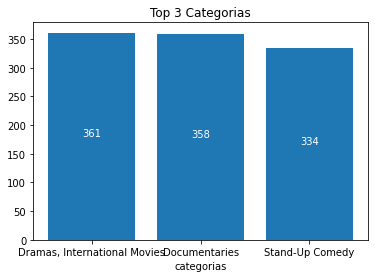

CPU times: user 130 ms, sys: 2.51 ms, total: 133 ms
Wall time: 136 ms


In [122]:
%%time

import matplotlib.pyplot as plt

# função para add valores nas barras 
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]//2, y[i], ha = 'center', color = 'white')

plt.bar(x=top_3_categorias.categorias, height=top_3_categorias.total)
plt.xlabel('categorias')
plt.title('Top 3 Categorias')
addlabels(x=top_3_categorias.categorias, y=top_3_categorias.total)
plt.show()

In [131]:
# Top 5 Países
%time paises = netflix.filter('pais IS NOT NULL')
%time paises = paises.groupBy('pais').agg(f.count('*').alias('total')).sort(f.desc('total'))
%time top_paises = paises.limit(5)
%time top_paises.show()
%time top_paises = top_paises.toPandas()
%time top_paises

CPU times: user 663 µs, sys: 0 ns, total: 663 µs
Wall time: 21.1 ms
CPU times: user 4.78 ms, sys: 1.1 ms, total: 5.89 ms
Wall time: 80.8 ms
CPU times: user 1.72 ms, sys: 45 µs, total: 1.76 ms
Wall time: 14.7 ms
+--------------+-----+
|          pais|total|
+--------------+-----+
| United States| 2806|
|         India|  972|
|United Kingdom|  419|
|         Japan|  245|
|   South Korea|  199|
+--------------+-----+

CPU times: user 17.6 ms, sys: 2.02 ms, total: 19.7 ms
Wall time: 2.3 s
CPU times: user 19 ms, sys: 3.99 ms, total: 23 ms
Wall time: 1.24 s
CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs


,pais,total
0,United States,2806
1,India,972
2,United Kingdom,419
3,Japan,245
4,South Korea,199


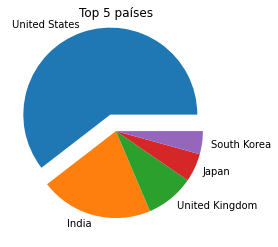

CPU times: user 94.9 ms, sys: 5.39 ms, total: 100 ms
Wall time: 276 ms


In [133]:
# plotando o gráfico de pizza
%%time 

label = top_paises.pais
myexplode = [0.2, 0, 0, 0, 0]
plt.pie(top_paises.total, labels=label, explode=myexplode)
plt.title('Top 5 países')
plt.show()

In [137]:
# retirnado os valores nulos do dataset

%time netflix_transformado = netflix.na.drop()
%time netflix_transformado.show(5)


CPU times: user 2.74 ms, sys: 0 ns, total: 2.74 ms
Wall time: 15.7 ms
+-------+-------+--------------------+-------------------+--------------------+--------------------+--------------+---------+---------+--------------------+--------------------+-------------+
|show_id|   tipo|              titulo|            diretor|              elenco|                pais|ano_lancamento|avaliacao|  duracao|          categorias|           descricao|adicionado_em|
+-------+-------+--------------------+-------------------+--------------------+--------------------+--------------+---------+---------+--------------------+--------------------+-------------+
|     s8|  Movie|             Sankofa|       Haile Gerima|Kofi Ghanaba, Oya...|United States, Gh...|          1993|    TV-MA|  125 min|Dramas, Independe...|On a photo shoot ...|   2021-09-24|
|     s9|TV Show|The Great British...|    Andy Devonshire|Mel Giedroyc, Sue...|      United Kingdom|          2021|    TV-14|9 Seasons|British TV Shows,...|A tale

In [139]:
%time netflix_transformado.count()

5312

In [146]:
from operator import contains
from numpy.lib.function_base import select
# separando o dataset por duração (Season)

%time season = netflix_transformado.filter(netflix_transformado.duracao.like('%Season%'))

season.show(5)
season.count()


CPU times: user 1.09 ms, sys: 965 µs, total: 2.06 ms
Wall time: 10.5 ms
+-------+-------+--------------------+--------------------+--------------------+--------------+--------------+---------+---------+--------------------+--------------------+-------------+
|show_id|   tipo|              titulo|             diretor|              elenco|          pais|ano_lancamento|avaliacao|  duracao|          categorias|           descricao|adicionado_em|
+-------+-------+--------------------+--------------------+--------------------+--------------+--------------+---------+---------+--------------------+--------------------+-------------+
|     s9|TV Show|The Great British...|     Andy Devonshire|Mel Giedroyc, Sue...|United Kingdom|          2021|    TV-14|9 Seasons|British TV Shows,...|A talented batch ...|   2021-09-24|
|   s274|TV Show|       Gone for Good|  Juan Carlos Medina|Finnegan Oldfield...|        France|          2021|    TV-MA| 1 Season|Crime TV Shows, I...|Ten years after l...|   2021-

142

In [148]:
# separando o dataset por duração (Minutos)

%time filmes_minutos = netflix_transformado.filter(netflix_transformado.duracao.contains('min'))
filmes_minutos.show(5)

CPU times: user 1.9 ms, sys: 0 ns, total: 1.9 ms
Wall time: 18.1 ms
+-------+-----+------------+-------------------+--------------------+--------------------+--------------+---------+-------+--------------------+--------------------+-------------+
|show_id| tipo|      titulo|            diretor|              elenco|                pais|ano_lancamento|avaliacao|duracao|          categorias|           descricao|adicionado_em|
+-------+-----+------------+-------------------+--------------------+--------------------+--------------+---------+-------+--------------------+--------------------+-------------+
|     s8|Movie|     Sankofa|       Haile Gerima|Kofi Ghanaba, Oya...|United States, Gh...|          1993|    TV-MA|125 min|Dramas, Independe...|On a photo shoot ...|   2021-09-24|
|    s10|Movie|The Starling|     Theodore Melfi|Melissa McCarthy,...|       United States|          2021|    PG-13|104 min|    Comedies, Dramas|A woman adjusting...|   2021-09-24|
|    s13|Movie|Je Suis Karl|Chri

In [150]:
# tranformando o valor da duração em minutos (str) para int
%time filmes_minutos = filmes_minutos.withColumn('duracao', f.regexp_replace('duracao', ' min', ''))
filmes_minutos.show(5)

CPU times: user 2.71 ms, sys: 49 µs, total: 2.76 ms
Wall time: 24.2 ms
+-------+-----+------------+-------------------+--------------------+--------------------+--------------+---------+-------+--------------------+--------------------+-------------+
|show_id| tipo|      titulo|            diretor|              elenco|                pais|ano_lancamento|avaliacao|duracao|          categorias|           descricao|adicionado_em|
+-------+-----+------------+-------------------+--------------------+--------------------+--------------+---------+-------+--------------------+--------------------+-------------+
|     s8|Movie|     Sankofa|       Haile Gerima|Kofi Ghanaba, Oya...|United States, Gh...|          1993|    TV-MA|    125|Dramas, Independe...|On a photo shoot ...|   2021-09-24|
|    s10|Movie|The Starling|     Theodore Melfi|Melissa McCarthy,...|       United States|          2021|    PG-13|    104|    Comedies, Dramas|A woman adjusting...|   2021-09-24|
|    s13|Movie|Je Suis Karl|C

In [153]:
%time filmes_minutos = filmes_minutos.withColumn('duracao', filmes_minutos['duracao'].cast(IntegerType()))
filmes_minutos.printSchema()

CPU times: user 1.86 ms, sys: 793 µs, total: 2.65 ms
Wall time: 13.9 ms
root
 |-- show_id: string (nullable = true)
 |-- tipo: string (nullable = true)
 |-- titulo: string (nullable = true)
 |-- diretor: string (nullable = true)
 |-- elenco: string (nullable = true)
 |-- pais: string (nullable = true)
 |-- ano_lancamento: integer (nullable = true)
 |-- avaliacao: string (nullable = true)
 |-- duracao: integer (nullable = true)
 |-- categorias: string (nullable = true)
 |-- descricao: string (nullable = true)
 |-- adicionado_em: date (nullable = true)



In [166]:
from numpy.core.fromnumeric import mean
# Média de duração dos filmes (min)

%time media_duracao = filmes_minutos.select(f.mean(filmes_minutos.duracao).alias('media'))
media_duracao = media_duracao.select(f.round('media', 2))
media_duracao.show()

CPU times: user 2.73 ms, sys: 0 ns, total: 2.73 ms
Wall time: 14.4 ms
+---------------+
|round(media, 2)|
+---------------+
|         102.69|
+---------------+



In [177]:
# Verificando as estatísticas básicas do dataset filmes_minutos

%time filmes_minutos.select("duracao").summary().show()

+-------+------------------+
|summary|           duracao|
+-------+------------------+
|  count|              5170|
|   mean| 102.6889748549323|
| stddev|25.914707009384237|
|    min|                 8|
|    25%|                89|
|    50%|               100|
|    75%|               116|
|    max|               253|
+-------+------------------+

CPU times: user 7.64 ms, sys: 0 ns, total: 7.64 ms
Wall time: 430 ms


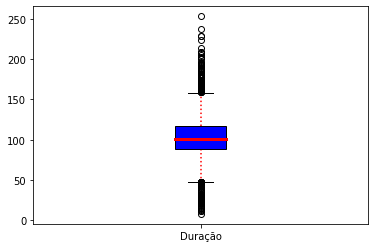

CPU times: user 246 ms, sys: 9.77 ms, total: 256 ms
Wall time: 1.15 s


In [178]:
%%time

# boxplot - verificando outliers

filmes_minutos_plot = filmes_minutos.toPandas()

bp = plt.boxplot(x='duracao', data=filmes_minutos_plot, vert=1, patch_artist=True, labels=['Duração'])
colors = 'blue'
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
for median in bp['medians']:
    median.set(color ='red',
               linewidth = 3)
for whisker in bp['whiskers']:
    whisker.set(color ='red',
                linewidth = 1.5,
                linestyle =":")
plt.show()